# Data Filtering & Imputation

## Data Filtering using time periods(1973~2022)

##### using start date(refer to full_info) available for each series, we can filter out available full series.

- full series available during 1973.2.~2022.12. are 207 features out of 233 features
- 1973.2. were used because most banking indicators are available from 1973.2. and we will impute one missing value for 1973.1 using the value of 1973.2.

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

In [2]:
syspath='../data'
#'C:/Users/gredi/Desktop/MADS/696_Milestone2/github/milestoneII/data'
#sys_path='/root/work/milestoneII/data' ## for deepnote

full_info=pd.read_csv(syspath+'/full_info.csv', parse_dates=['start','end'])
full_data=pd.read_csv(syspath+'/full_data.csv', index_col='date',parse_dates=True)

In [3]:
full_data.dtypes

RPI                float64
W875RX1            float64
DPCERA3M086SBEA    float64
CMRMTSPLx          float64
RETAILx            float64
                    ...   
5Y6M               float64
10Y6M              float64
5Y1Y               float64
10Y1Y              float64
10Y5Y              float64
Length: 233, dtype: object

In [4]:
use_varlist=list(full_info.loc[
    (full_info.start<=pd.Timestamp(1973,2,1))&
    (full_info.end>=pd.Timestamp(2022,12,1))
]['id']) ##.groupby('group').count()['id']

discard_varlist=list(full_info.loc[
    (full_info.start>pd.Timestamp(1973,2,1))|
    (full_info.end<pd.Timestamp(2022,12,1))
]['id']) #.groupby('group').count()

sa_table=full_info.loc[full_info.id.isin(use_varlist)][['id','seasonal_adjustment_short']].groupby('seasonal_adjustment_short').count()

length_table=full_info.loc[full_info.id.isin(discard_varlist)][['title','start']].groupby(['start','title']).count()


table1=full_info.loc[full_info.id.isin(use_varlist)][['id','group']].groupby('group').count()

ref_table=pd.read_excel(syspath+'/FRED-MD_updated_appendix.xlsx',
                       sheet_name='REF')

table2=ref_table.loc[ref_table.category=='group'][['value','description']]

group_table=table1.merge(table2, how='left', left_index=True, right_on='value'
            ).rename(columns={'id':'count', 'value':'group'})

len(use_varlist), group_table

(207,
     count  group                           description
 0       9      0                     label, cycle, gdp
 1      16      1                     output and income
 2      31      2                         labour market
 3      11      3                               housing
 4       8      4  consumption, orders, and inventories
 5      13      5                      money and credit
 6      32      6           interest and exchange rates
 7      52      7                                prices
 8       9      8                          stock market
 9      10      9                             sentiment
 10     16     10                               banking)

In [5]:
#list(full_info.loc[full_info.seasonal_adjustment_short=='NSA']['title'])
#full_info.loc[full_info.tcode.isin([1,4])]['title']

10


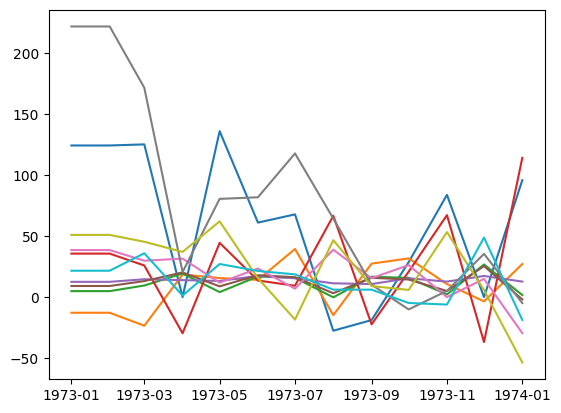

In [6]:
## simple imputation for one missing value(1973/1/1) in 10 banking indicators
## imputation method=use the following value

missing_var=list(full_info.loc[full_info.start==pd.Timestamp(1973,2,1)]['id'])
print(len(missing_var)) ## 10indicators for banking sector(1973-01-01 missing)

for var in missing_var:
    full_data.loc[pd.Timestamp(1973,1,1), var]=full_data.loc[pd.Timestamp(1973,2,1), var]
    
full_data.loc[[pd.Timestamp(1973,1,1),pd.Timestamp(1973,2,1)], missing_var]

plt.plot(full_data[missing_var][pd.Timestamp(1973,1,1):pd.Timestamp(1974,1,1)]);


In [7]:
use_varlist=list(full_info.loc[
    (full_info.start<=pd.Timestamp(1973,1,1))&
    (full_info.end>=pd.Timestamp(2022,12,1))
]['id'])+missing_var

#len(use_varlist)  ##207 features including target variable

discard_varlist=[x for x in list(full_info.id) if x not in use_varlist]

In [8]:
len(use_varlist), len(discard_varlist)

(207, 26)

In [9]:
## setting filtered_data using period(1973/1 ~ 2022/12)
full_data = full_data.replace(to_replace='.', value=np.nan)
full_data = full_data.astype('float64')

filtered_data = full_data[use_varlist][pd.Timestamp(1973,1,1):pd.Timestamp(2022,12,1)]

## Data Imputation using linear interpolation 

##### It was found that some series have missing values in the midst of the periods(1973.1~2022.12), and we will use linear interpolation to impute missing values. 
- We decided to drop one series('WPU142') out of 5 series which need imputation, because it has too many missing values(192) 
- For series 'UMCSENTx', the missing values occur due to change in release frequencies from quarter to month. So we've decided to generate missing monthly values using quarterly values for early parts of the series.

In [10]:
## checking if there another nan values for containing series
## there exists 3 series with missing values
## it is possible because we first filter the variables with 
## just metadata information of start_date, end_date
## if some missing values exist between the existing value in the series,
## the series will be detected at this point.

null_dict=dict(filtered_data.isna().sum())
null_list=[x for x in null_dict.keys() if null_dict[x]!=0]
print([(x, null_dict[x]) for x in null_list])
filtered_data[null_list].head(5)

[('CP3Mx', 1), ('COMPAPFFx', 1), ('UMCSENTx', 40), ('WPSID6222', 192), ('WPU142', 4)]


CP3Mx  COMPAPFFx  UMCSENTx  WPSID6222  WPU142
date                                                     
1973-01-01   5.77      -0.17       NaN       17.5    38.6
1973-02-01   6.17      -0.41      81.9       17.7    38.8
1973-03-01   6.76      -0.33       NaN       17.9    39.0
1973-04-01   7.13       0.01       NaN       18.0    39.0
1973-05-01   7.26      -0.58      77.0       18.2    39.0

In [11]:
null_list

['CP3Mx', 'COMPAPFFx', 'UMCSENTx', 'WPSID6222', 'WPU142']

In [12]:
## null_list[3]: drop due to too many missing values (missing values in certain period)
## null_list[0,1,2,3]: apply linear interpolation, 
## for 'UMCSENTx', the series changed from quarterly data to monthly data from 1978

null_list.remove('WPSID6222')  ## the variable to apply linear interpolation
use_varlist.remove('WPSID6222') ## the variable to use in the analysis
discard_varlist=discard_varlist+['WPSID6222']  ## the variable not to use in the analysis

In [13]:
## uncomment to figure out the index of missing value

# for var in null_list:
#     print('{}:'.format(var),filtered_data[filtered_data.isna()[var]==True][var])

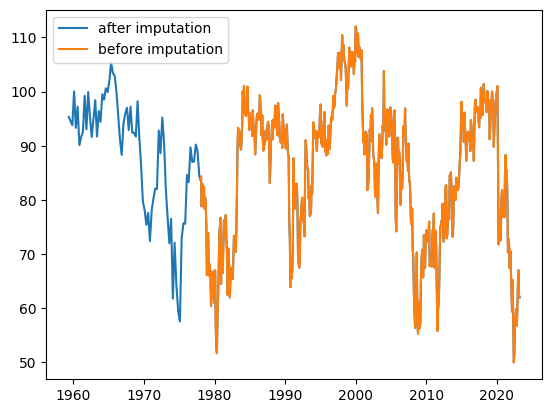

In [14]:
## imputation methods: linear interpolation
## the example plot is for 'UMCSENTx' (other 2 series has only one missing value)

fig, ax=plt.subplots()
ax.plot(full_data['UMCSENTx'].interpolate(method='linear'), label='after imputation')
ax.plot(full_data['UMCSENTx'], label='before imputation')
ax.legend()

for x in range(len(null_list)):
    full_data[null_list[x]]=full_data[null_list[x]].interpolate(method='linear')

In [15]:
len(use_varlist)
dict(full_data.isnull().sum())

{'RPI': 1,
 'W875RX1': 1,
 'DPCERA3M086SBEA': 1,
 'CMRMTSPLx': 2,
 'RETAILx': 1,
 'INDPRO': 1,
 'IPFPNSS': 1,
 'IPFINAL': 1,
 'IPCONGD': 1,
 'IPDCONGD': 1,
 'IPNCONGD': 1,
 'IPBUSEQ': 1,
 'IPMAT': 1,
 'IPDMAT': 1,
 'IPNMAT': 1,
 'IPMANSICS': 1,
 'IPB51222S': 1,
 'IPFUELS': 1,
 'CUMFNS': 1,
 'HWI': 2,
 'HWIURATIO': 2,
 'CLF16OV': 1,
 'CE16OV': 1,
 'UNRATE': 1,
 'UEMPMEAN': 1,
 'UEMPLT5': 1,
 'UEMP5TO14': 1,
 'UEMP15OV': 1,
 'UEMP15T26': 1,
 'UEMP27OV': 1,
 'CLAIMSx': 1,
 'PAYEMS': 1,
 'USGOOD': 1,
 'CES1021000001': 1,
 'USCONS': 1,
 'MANEMP': 1,
 'DMANEMP': 1,
 'NDMANEMP': 1,
 'SRVPRD': 1,
 'USTPU': 1,
 'USWTRADE': 1,
 'USTRADE': 1,
 'USFIRE': 1,
 'USGOVT': 1,
 'CES0600000007': 1,
 'AWOTMAN': 1,
 'AWHMAN': 1,
 'HOUST': 1,
 'HOUSTNE': 1,
 'HOUSTMW': 1,
 'HOUSTS': 1,
 'HOUSTW': 1,
 'PERMIT': 13,
 'PERMITNE': 13,
 'PERMITMW': 13,
 'PERMITS': 13,
 'PERMITW': 13,
 'ACOGNO': 399,
 'AMDMNOx': 1,
 'ANDENOx': 110,
 'AMDMUOx': 1,
 'BUSINVx': 2,
 'ISRATIOx': 2,
 'M1SL': 1,
 'M2SL': 1,
 'M2REAL': 1

# Stationarity Test

## Stationarity Test for imputed data without transformation(ex. log difference)

##### Let's do some Augmented Dickey Fuller Test to check if the features are stationary or not.
- If p-value is less than 0.1, then it means that we can reject the null hypothesis that the series is non-stationary under 90% confidence interval. In other words, if p-value is less than 0.1, we can say that the series is considered to be stationary with 90% confidence.
- For imputed data during 1974~2022, there exists 131 non-stationary data out of 206 features.
> I chose the start year as 1974 considering that future transformation towards the data includes year-on-year log difference which will reduce the length of observations by 1 year.
- It seems non-stationary data is more prevalent than stationary ones. And we should consider using time-series classification methods which won't depend on the stationarity of inputs such as Random Forest, Support Vector Machines, Gradient Boosting(XGBoost), Deep Neural Networks(LSTM, GRU, DBN), Dynamic Time Warping(DTW).

In [16]:
## setting imputed_data using period(1974/1 ~ 2022/12)
full_data_imp=full_data[use_varlist]
full_data_imp.to_csv (syspath+'/full_data_imp.csv', index = True, header=True)

imputed_data=full_data[use_varlist][pd.Timestamp(1974,1,1):pd.Timestamp(2022,12,1)]
dict(imputed_data.dtypes)
imputed_data=imputed_data.astype('float64')

In [18]:
imputed_data['WPU142']

date
1974-01-01     39.200
1974-02-01     39.200
1974-03-01     39.200
1974-04-01     39.700
1974-05-01     41.800
               ...   
2022-08-01    295.772
2022-09-01    296.865
2022-10-01    297.361
2022-11-01    297.779
2022-12-01    298.741
Name: WPU142, Length: 588, dtype: float64

In [19]:
var_list=[]
pvalue=[]

for idx, var in enumerate(use_varlist):
    X=imputed_data[var].values
    result = adfuller(X)
    var_list.append(var)
    pvalue.append(result[1])

adf_df=pd.DataFrame({'var':var_list,'pvalue':pvalue})
adf_df['stationary']=adf_df['pvalue'].apply(lambda x:1 if x<0.1 else 0)
# print('ADF Statistic: %f' % result[0])
# print('p-value: %f' % result[1])
# print('Critical Values:')
# for key, value in result[4].items():
#  print('\t%s: %.3f' % (key, value))

nonst_varlist=adf_df.loc[adf_df.stationary==0]
full_info=pd.read_csv(syspath+'/full_info.csv')

## see non-stationary series
print(len(nonst_varlist))
list(nonst_varlist.merge(full_info, how='left', left_on='var', right_on='id')['title'])

131


['Real Personal Income',
 'Real personal income excluding current transfer receipts',
 'Real personal consumption expenditures (chain-type quantity index)',
 'Real Manu.  and Trade Industries Sales',
 'Retail and Food Services Sales',
 'Industrial Production: Total Index',
 'Industrial Production: Final Products and Nonindustrial Supplies',
 'Industrial Production: Final Products',
 'Industrial Production: Consumer Goods',
 'Industrial Production: Durable Consumer Goods',
 'Industrial Production: Non-Durable Consumer Goods',
 'Industrial Production: Equipment: Business Equipment',
 'Industrial Production: Materials',
 'Industrial Production: Durable Goods Materials',
 'Industrial Production: Manufacturing (SIC)',
 'Industrial Production: Non-Durable Consumer Energy Products: Residential Utilities',
 'Industrial Production: Non-Durable Consumer Energy Products: Fuels',
 'Help-Wanted Index for United States',
 'Ratio of Help Wanted/No.  Unemployed',
 'Employment Level',
 'Average Weeks U

In [20]:
y_list=list(full_info[full_info.group==0]['id'])
X_list=[x for x in use_varlist if x not in y_list]

len(discard_varlist), len(use_varlist), len(X_list), len(y_list)

(27, 206, 197, 9)

In [21]:
## explanatory variables and dependent variables
Xy_data=imputed_data[use_varlist]
y_data=imputed_data[y_list]
X_data=imputed_data[X_list]

Xy_data.to_csv (syspath+'/Xy_data.csv', index = True, header=True)
X_data.to_csv (syspath+'/X_data.csv', index = True, header=True)
y_data.to_csv (syspath+'/y_data.csv', index = True, header=True)

## Stationarity Test for imputed data with transformation(ex. log difference)

##### We will first transform the imputed data referring to the tcode in full_info. tcode denotes for recommended transformation method of the features. For example, if tcode is 5, it means that the series needs to be transformed to log difference for more stationarity and interpretability.


##### Let's do Augmented Dickey Fuller Test again for imputed & transformed data to check if the features are stationary or not.
- If p-value is less than 0.1, then it means that we can reject the null hypothesis that the series is non-stationary under 90% confidence interval. In other words, if p-value is less than 0.1, we can say that the series is considered to be stationary with 90% confidence.
- For imputed data during 1974~2022, there exists 12 non-stationary data out of 206 features.
> I chose the start year as 1974 considering that the transformation towards the data includes year-on-year log difference which will reduce the length of observations by 1 year.
- It seems that the number of non-stationary data has been drastically reduced compared to that of imputed but non-transformed data.
> the number of non-stationary features: 131 -> 12

In [22]:
#full_data_imp

def transform(data, metadata, tcode):
    
    var_list=list(metadata[metadata.tcode==tcode]['id'])
    
    sel_list=[x for x in var_list if x in data.columns]
    
    df=data[sel_list]
    
#    print(df.head())
    
    if tcode==2:
        df_transform=df.diff()
    elif tcode==3:
        df_transform=df.diff().diff()
    elif tcode==4:
        df_transform=np.log(df)
    elif tcode==5:
        df_transform=np.log(df/df.shift(1))
    elif tcode==6:
        df_transform=np.log(df/df.shift(1))-np.log(df.shift(1)/df.shift(2))
    elif tcode==7:
        df_transform=(df/df.shift(1)-1).diff()
    elif tcode==51:
        df_transform=np.log(df/df.shift(12))
    else: 
        df_transform=df
        
    return df_transform


for idx, tcode in enumerate(set(full_info.tcode.unique())):

    if idx==0:
        df_transform=transform(full_data_imp, full_info, tcode)
    else:
        df_temp=transform(full_data_imp, full_info, tcode)
        df_transform=df_transform.merge(df_temp, how='left', left_index=True, right_index=True)

print(df_transform.shape==full_data_imp.shape)
print(set(df_transform.columns)==set(full_data_imp.columns))
df_transform.tail()
    

True
True


CES0600000007  AWHMAN  COMPAPFFx  TB3SMFFM  TB6SMFFM  T1YFFM   
date                                                                       
2022-12-01           40.3    40.6       0.41      0.16      0.46    0.59  \
2023-01-01           40.7    40.9       0.28      0.21      0.34    0.36   
2023-02-01           40.6    40.7       0.17      0.08      0.24    0.36   
2023-03-01           40.5    40.7       0.26      0.04      0.12    0.03   
2023-04-01            NaN     NaN       0.26       NaN       NaN     NaN   

            T5YFFM  T10YFFM  AAAFFM  BAAFFM  ...    WPU102    WPU114   
date                                         ...                       
2022-12-01   -0.33    -0.47    0.34    1.50  ... -0.005853  0.121450  \
2023-01-01   -0.69    -0.80    0.07    1.17  ... -0.012993  0.110777   
2023-02-01   -0.63    -0.82   -0.01    1.02  ... -0.050785  0.099286   
2023-03-01   -0.83    -0.99   -0.05    1.06  ... -0.094077  0.096059   
2023-04-01     NaN      NaN     NaN     NaN  ... -0.108660  0.087916   

              WPU117   WPU1178    WPU142  NASDAQCOM  WILL5000IND   
date                                                               
2022-12-01  0.068204  0.043920  0.042949  -0.356039    -0.174459  \
2023-01-01  0.060341  0.022217  0.044064  -0.277144    -0.132236   
2023-02-01  0.053841  0.022362  0.048474  -0.164963    -0.068967   
2023-03-01  0.048973  0.017915  0.043078  -0.157581    -0.092096   
2023-04-01  0.045230  0.016512  0.044091  -0.103809    -0.056775   

            WILL5000INDFC  WILL5000PR  WILL5000PRFC  
date                                                 
2022-12-01      -0.188892   -0.190602     -0.204925  
2023-01-01      -0.141200   -0.148689     -0.157564  
2023-02-01      -0.076275   -0.085630     -0.092802  
2023-03-01      -0.098265   -0.109145     -0.115118  
2023-04-01      -0.062286   -0.074015     -0.079379  

[5 rows x 206 columns]

In [23]:
final_data=df_transform[use_varlist][pd.Timestamp(1974,1,1):pd.Timestamp(2022,12,1)]
dict(final_data.dtypes)
final_data=final_data.astype('float64')

In [24]:
dict(final_data.isnull().sum())

{'RPI': 0,
 'W875RX1': 0,
 'DPCERA3M086SBEA': 0,
 'CMRMTSPLx': 0,
 'RETAILx': 0,
 'INDPRO': 0,
 'IPFPNSS': 0,
 'IPFINAL': 0,
 'IPCONGD': 0,
 'IPDCONGD': 0,
 'IPNCONGD': 0,
 'IPBUSEQ': 0,
 'IPMAT': 0,
 'IPDMAT': 0,
 'IPNMAT': 0,
 'IPMANSICS': 0,
 'IPB51222S': 0,
 'IPFUELS': 0,
 'CUMFNS': 0,
 'HWI': 0,
 'HWIURATIO': 0,
 'CLF16OV': 0,
 'CE16OV': 0,
 'UNRATE': 0,
 'UEMPMEAN': 0,
 'UEMPLT5': 0,
 'UEMP5TO14': 0,
 'UEMP15OV': 0,
 'UEMP15T26': 0,
 'UEMP27OV': 0,
 'CLAIMSx': 0,
 'PAYEMS': 0,
 'USGOOD': 0,
 'CES1021000001': 0,
 'USCONS': 0,
 'MANEMP': 0,
 'DMANEMP': 0,
 'NDMANEMP': 0,
 'SRVPRD': 0,
 'USTPU': 0,
 'USWTRADE': 0,
 'USTRADE': 0,
 'USFIRE': 0,
 'USGOVT': 0,
 'CES0600000007': 0,
 'AWOTMAN': 0,
 'AWHMAN': 0,
 'HOUST': 0,
 'HOUSTNE': 0,
 'HOUSTMW': 0,
 'HOUSTS': 0,
 'HOUSTW': 0,
 'PERMIT': 0,
 'PERMITNE': 0,
 'PERMITMW': 0,
 'PERMITS': 0,
 'PERMITW': 0,
 'AMDMNOx': 0,
 'ANDENOx': 0,
 'AMDMUOx': 0,
 'BUSINVx': 0,
 'ISRATIOx': 0,
 'M1SL': 0,
 'M2SL': 0,
 'M2REAL': 0,
 'BOGMBASE': 0,
 'TOT

In [25]:
var_list=[]
pvalue=[]

for idx, var in enumerate(use_varlist):
    X=final_data[var].values
    result = adfuller(X)
    var_list.append(var)
    pvalue.append(result[1])

adf_df=pd.DataFrame({'var':var_list,'pvalue':pvalue})
adf_df['stationary']=adf_df['pvalue'].apply(lambda x:1 if x<0.1 else 0)
# print('ADF Statistic: %f' % result[0])
# print('p-value: %f' % result[1])
# print('Critical Values:')
# for key, value in result[4].items():
#  print('\t%s: %.3f' % (key, value))

nonst_varlist=adf_df.loc[adf_df.stationary==0]
full_info=pd.read_csv(syspath+'/full_info.csv')

## see non-stationary series
print(len(nonst_varlist))
list(nonst_varlist.merge(full_info, how='left', left_on='var', right_on='id')['title'])

12


['New Privately-Owned Housing Units Started: Total Units',
 'New Privately-Owned Housing Units Started: Total Units in the Northeast Census Region',
 'New Privately-Owned Housing Units Started: Total Units in the Midwest Census Region',
 'New Privately-Owned Housing Units Authorized in Permit-Issuing Places: Total Units',
 'New Privately-Owned Housing Units Authorized in Permit-Issuing Places: Total Units in the Midwest Census Region',
 'Trend restored (CLI)',
 'Trend (GDP)',
 'consumer opinion:  Confidence indicators    National indicator',
 'Consumer Price Index for All Urban Consumers: Medical Care in U.S. City Average',
 'Consumer Price Index for All Urban Consumers: Other Goods and Services in U.S. City Average',
 'Producer Price Index by Commodity: Machinery and Equipment: Electronic Components and Accessories',
 'Producer Price Index by Commodity: Transportation Equipment: Aircraft and Aircraft Equipment']

In [26]:
adf_df[adf_df.stationary==0]

var    pvalue  stationary
47      HOUST  0.218101           0
48    HOUSTNE  0.181250           0
49    HOUSTMW  0.231169           0
52     PERMIT  0.169960           0
54   PERMITMW  0.235619           0
128     CLI_T  0.992229           0
133     GDP_T  0.995110           0
139       CSI  0.121849           0
156  CPIMEDNS  0.285049           0
157  CPIOGSNS  0.214658           0
178   WPU1178  0.225972           0
179    WPU142  0.105416           0

# Save the dataset for the analysis (two versions)

##### Save imputed & non-transformed data as Xy_data, X_data, y_data (1974.1~2022.12)

##### Save imputed & transformed data as Xy_data_tr, X_data_tr, y_data_tr (1974.1~2022.12)

In [27]:
## explanatory variables and dependent variables
Xy_data=final_data[use_varlist]
y_data=final_data[y_list]
X_data=final_data[X_list]

Xy_data.to_csv (syspath+'/Xy_data_tr.csv', index = True, header=True)
X_data.to_csv (syspath+'/X_data_tr.csv', index = True, header=True)
y_data.to_csv (syspath+'/y_data_tr.csv', index = True, header=True)


In [28]:
pd.read_csv(syspath+'/y_data_tr.csv', index_col='date', parse_dates=True).head(5)

CLI_MA  CLI_N  CLI_T  GDP_RTT  GDP_N  GDP_T  y_nber  y_oecd  y_agg
date                                                                          
1974-01-01   100.5  100.4   32.4    101.8  101.6   32.2     1.0     1.0    2.0
1974-02-01   100.2  100.2   32.4    101.5  101.3   32.3     1.0     1.0    2.0
1974-03-01    99.9   99.9   32.3    101.2  101.1   32.4     1.0     1.0    2.0
1974-04-01    99.5   99.6   32.3    100.9  100.8   32.4     1.0     1.0    2.0
1974-05-01    99.1   99.2   32.2    100.5  100.5   32.5     1.0     1.0    2.0

In [29]:
pd.read_csv(syspath+'/X_data_tr.csv', index_col='date', parse_dates=True).head(5)

RPI   W875RX1  DPCERA3M086SBEA  CMRMTSPLx   RETAILx   
date                                                                   
1974-01-01 -0.008564 -0.011916        -0.000559   0.000901  0.012460  \
1974-02-01 -0.006029 -0.006476        -0.005798  -0.004919  0.005931   
1974-03-01 -0.006566 -0.006938         0.001562   0.003376  0.014301   
1974-04-01 -0.000595 -0.004942         0.003335  -0.007316  0.013271   
1974-05-01  0.000902  0.000657         0.002920   0.004392  0.011373   

              INDPRO   IPFPNSS   IPFINAL   IPCONGD  IPDCONGD  ...   
date                                                          ...   
1974-01-01 -0.006620 -0.006027 -0.009055 -0.013168 -0.051689  ...  \
1974-02-01 -0.002892 -0.003727 -0.002490 -0.003025 -0.001971  ...   
1974-03-01 -0.000165  0.002957  0.003684  0.001733  0.000346  ...   
1974-04-01 -0.003038 -0.004562 -0.005242 -0.003045 -0.007320  ...   
1974-05-01  0.008044  0.009300  0.010782  0.009367  0.004069  ...   

            H8B1047NCBCMG  H8B1048NCBCMG  H8B1058NCBCMG  H8B1091NCBCMG   
date                                                                     
1974-01-01           95.7           27.1            1.7          114.0  \
1974-02-01          -64.4           21.9           -2.1           56.4   
1974-03-01           42.6            2.3            7.5           56.4   
1974-04-01           65.8           -6.8           31.2          -57.8   
1974-05-01           39.0           21.6            4.9            0.8   

            H8B1151NCBCMG  H8B1152NCBCMG  H8B3053NCBCMG  H8B3094NCBCMG   
date                                                                     
1974-01-01           12.7           -1.9          -29.5           -4.9  \
1974-02-01            8.8            1.1           23.8          -29.6   
1974-03-01           16.8           10.2           33.9           45.6   
1974-04-01           16.8           29.6           30.9           53.7   
1974-05-01            7.4            8.5            2.0           93.4   

            H8B3095NCBCMG  H8B3305NCBCMG  
date                                      
1974-01-01          -53.5          -18.7  
1974-02-01           70.8           -2.4  
1974-03-01           33.4           25.0  
1974-04-01           -8.1           42.0  
1974-05-01           30.0           23.7  

[5 rows x 197 columns]

In [30]:
pd.read_csv(syspath+'/y_data.csv', index_col='date', parse_dates=True).head(5)

CLI_MA  CLI_N  CLI_T  GDP_RTT  GDP_N  GDP_T  y_nber  y_oecd  y_agg
date                                                                          
1974-01-01   100.5  100.4   32.4    101.8  101.6   32.2     1.0     1.0    2.0
1974-02-01   100.2  100.2   32.4    101.5  101.3   32.3     1.0     1.0    2.0
1974-03-01    99.9   99.9   32.3    101.2  101.1   32.4     1.0     1.0    2.0
1974-04-01    99.5   99.6   32.3    100.9  100.8   32.4     1.0     1.0    2.0
1974-05-01    99.1   99.2   32.2    100.5  100.5   32.5     1.0     1.0    2.0

In [31]:
pd.read_csv(syspath+'/X_data.csv', index_col='date', parse_dates=True).head(5)

RPI  W875RX1  DPCERA3M086SBEA   CMRMTSPLx      RETAILx   
date                                                                      
1974-01-01  4823.641   4337.8           32.171  526877.275  44807.96089  \
1974-02-01  4794.649   4309.8           31.985  524291.718  45074.50209   
1974-03-01  4763.270   4280.0           32.035  526064.925  45723.74252   
1974-04-01  4760.436   4258.9           32.142  522230.381  46334.60931   
1974-05-01  4764.730   4261.7           32.236  524529.077  46864.58033   

             INDPRO  IPFPNSS  IPFINAL  IPCONGD  IPDCONGD  ...  H8B1047NCBCMG   
date                                                      ...                  
1974-01-01  45.5297  47.3429  44.8744  60.3606   43.4248  ...           95.7  \
1974-02-01  45.3982  47.1668  44.7628  60.1783   43.3393  ...          -64.4   
1974-03-01  45.3907  47.3065  44.9280  60.2827   43.3543  ...           42.6   
1974-04-01  45.2530  47.0912  44.6931  60.0994   43.0381  ...           65.8   
1974-05-01  45.6185  47.5312  45.1776  60.6650   43.2136  ...           39.0   

            H8B1048NCBCMG  H8B1058NCBCMG  H8B1091NCBCMG  H8B1151NCBCMG   
date                                                                     
1974-01-01           27.1            1.7          114.0           12.7  \
1974-02-01           21.9           -2.1           56.4            8.8   
1974-03-01            2.3            7.5           56.4           16.8   
1974-04-01           -6.8           31.2          -57.8           16.8   
1974-05-01           21.6            4.9            0.8            7.4   

            H8B1152NCBCMG  H8B3053NCBCMG  H8B3094NCBCMG  H8B3095NCBCMG   
date                                                                     
1974-01-01           -1.9          -29.5           -4.9          -53.5  \
1974-02-01            1.1           23.8          -29.6           70.8   
1974-03-01           10.2           33.9           45.6           33.4   
1974-04-01           29.6           30.9           53.7           -8.1   
1974-05-01            8.5            2.0           93.4           30.0   

            H8B3305NCBCMG  
date                       
1974-01-01          -18.7  
1974-02-01           -2.4  
1974-03-01           25.0  
1974-04-01           42.0  
1974-05-01           23.7  

[5 rows x 197 columns]